In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")

import requests

In [2]:
data = pd.read_csv('housing.csv', delimiter=',')
data

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
0            NEAR BAY  
1            NEAR BAY  
2            NEAR BAY  
3            NEAR BAY  
4            NEAR BAY  
...               ...  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAND  
20639          INLAND  

[20640 rows x 10 columns]

In [31]:
#for i in tqdm.tqdm(data.index):
#    d = data.loc[i]
#    r = requests.get('https://geo.fcc.gov/api/census/area?lat={0}&lon={1}&format=json'.format(d['latitude'], d['longitude']))
#    data['county'] = r.json()['results'][0]['county_name']

In [3]:
import aiohttp
import asyncio

async with aiohttp.ClientSession() as session:
    async def get_counties():
        res = []
        async def get_county(lat, lon):       
            async with session.get('https://geo.fcc.gov/api/census/area?lat={0}&lon={1}&format=json'.format(lat, lon)) as response:
                try:
                  json = await response.json()                
                  return json['results'][0]['county_name']
                except:
                  return 'unknown'
        for i in data.index:
            d = data.loc[i]
            res.append(get_county(d['latitude'], d['longitude']))
        return res

    counties = await get_counties()
    data['county'] = await asyncio.gather(*counties)

In [4]:
data.ocean_proximity = data.ocean_proximity.astype('category')
data.county = data.county.astype('category')

In [5]:
data["county"].value_counts()

Los Angeles    5824
Orange         1618
San Diego      1609
Alameda        1017
Santa Clara    1004
               ... 
Sierra            8
Alpine            3
Douglas           1
La Paz            1
unknown           1
Name: county, Length: 61, dtype: int64

(array([   9.,   14.,   61.,  255.,  538.,  676.,  546.,  803.,  881.,
         706.,  812.,  715.,  836.,  815.,  921.,  960.,  786.,  817.,
         703.,  505.,  620.,  661.,  578.,  508.,  437.,  434.,  463.,
         331.,  320.,  216.,  224.,  232.,  245.,  252.,  286.,  193.,
         160.,  149.,  117.,  133.,  104.,   99.,   80.,   90.,  106.,
          66.,   49.,   51.,   47., 1030.]),
 array([ 14999.  ,  24699.04,  34399.08,  44099.12,  53799.16,  63499.2 ,
         73199.24,  82899.28,  92599.32, 102299.36, 111999.4 , 121699.44,
        131399.48, 141099.52, 150799.56, 160499.6 , 170199.64, 179899.68,
        189599.72, 199299.76, 208999.8 , 218699.84, 228399.88, 238099.92,
        247799.96, 257500.  , 267200.04, 276900.08, 286600.12, 296300.16,
        306000.2 , 315700.24, 325400.28, 335100.32, 344800.36, 354500.4 ,
        364200.44, 373900.48, 383600.52, 393300.56, 403000.6 , 412700.64,
        422400.68, 432100.72, 441800.76, 451500.8 , 461200.84, 470900.88,
        

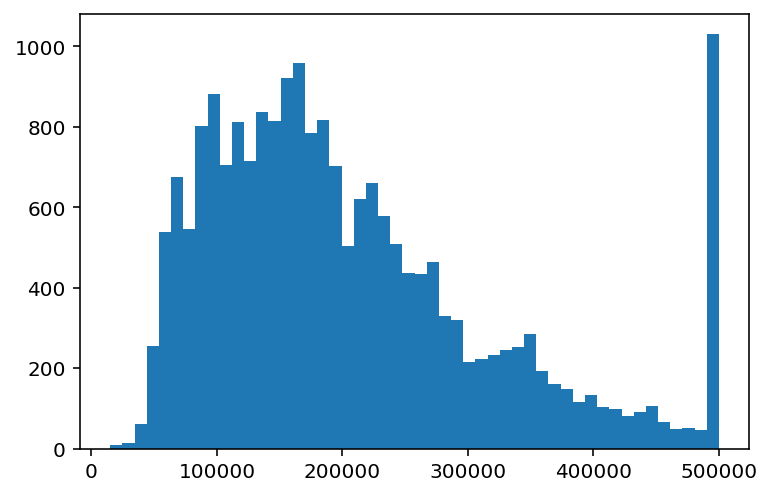

In [6]:
plt.hist(data.median_house_value, bins=50)

In [9]:
corr_matrix = data.corr()
corr_matrix['median_house_value']

longitude            -0.045967
latitude             -0.144160
housing_median_age    0.105623
total_rooms           0.134153
total_bedrooms        0.049686
population           -0.024650
households            0.065843
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

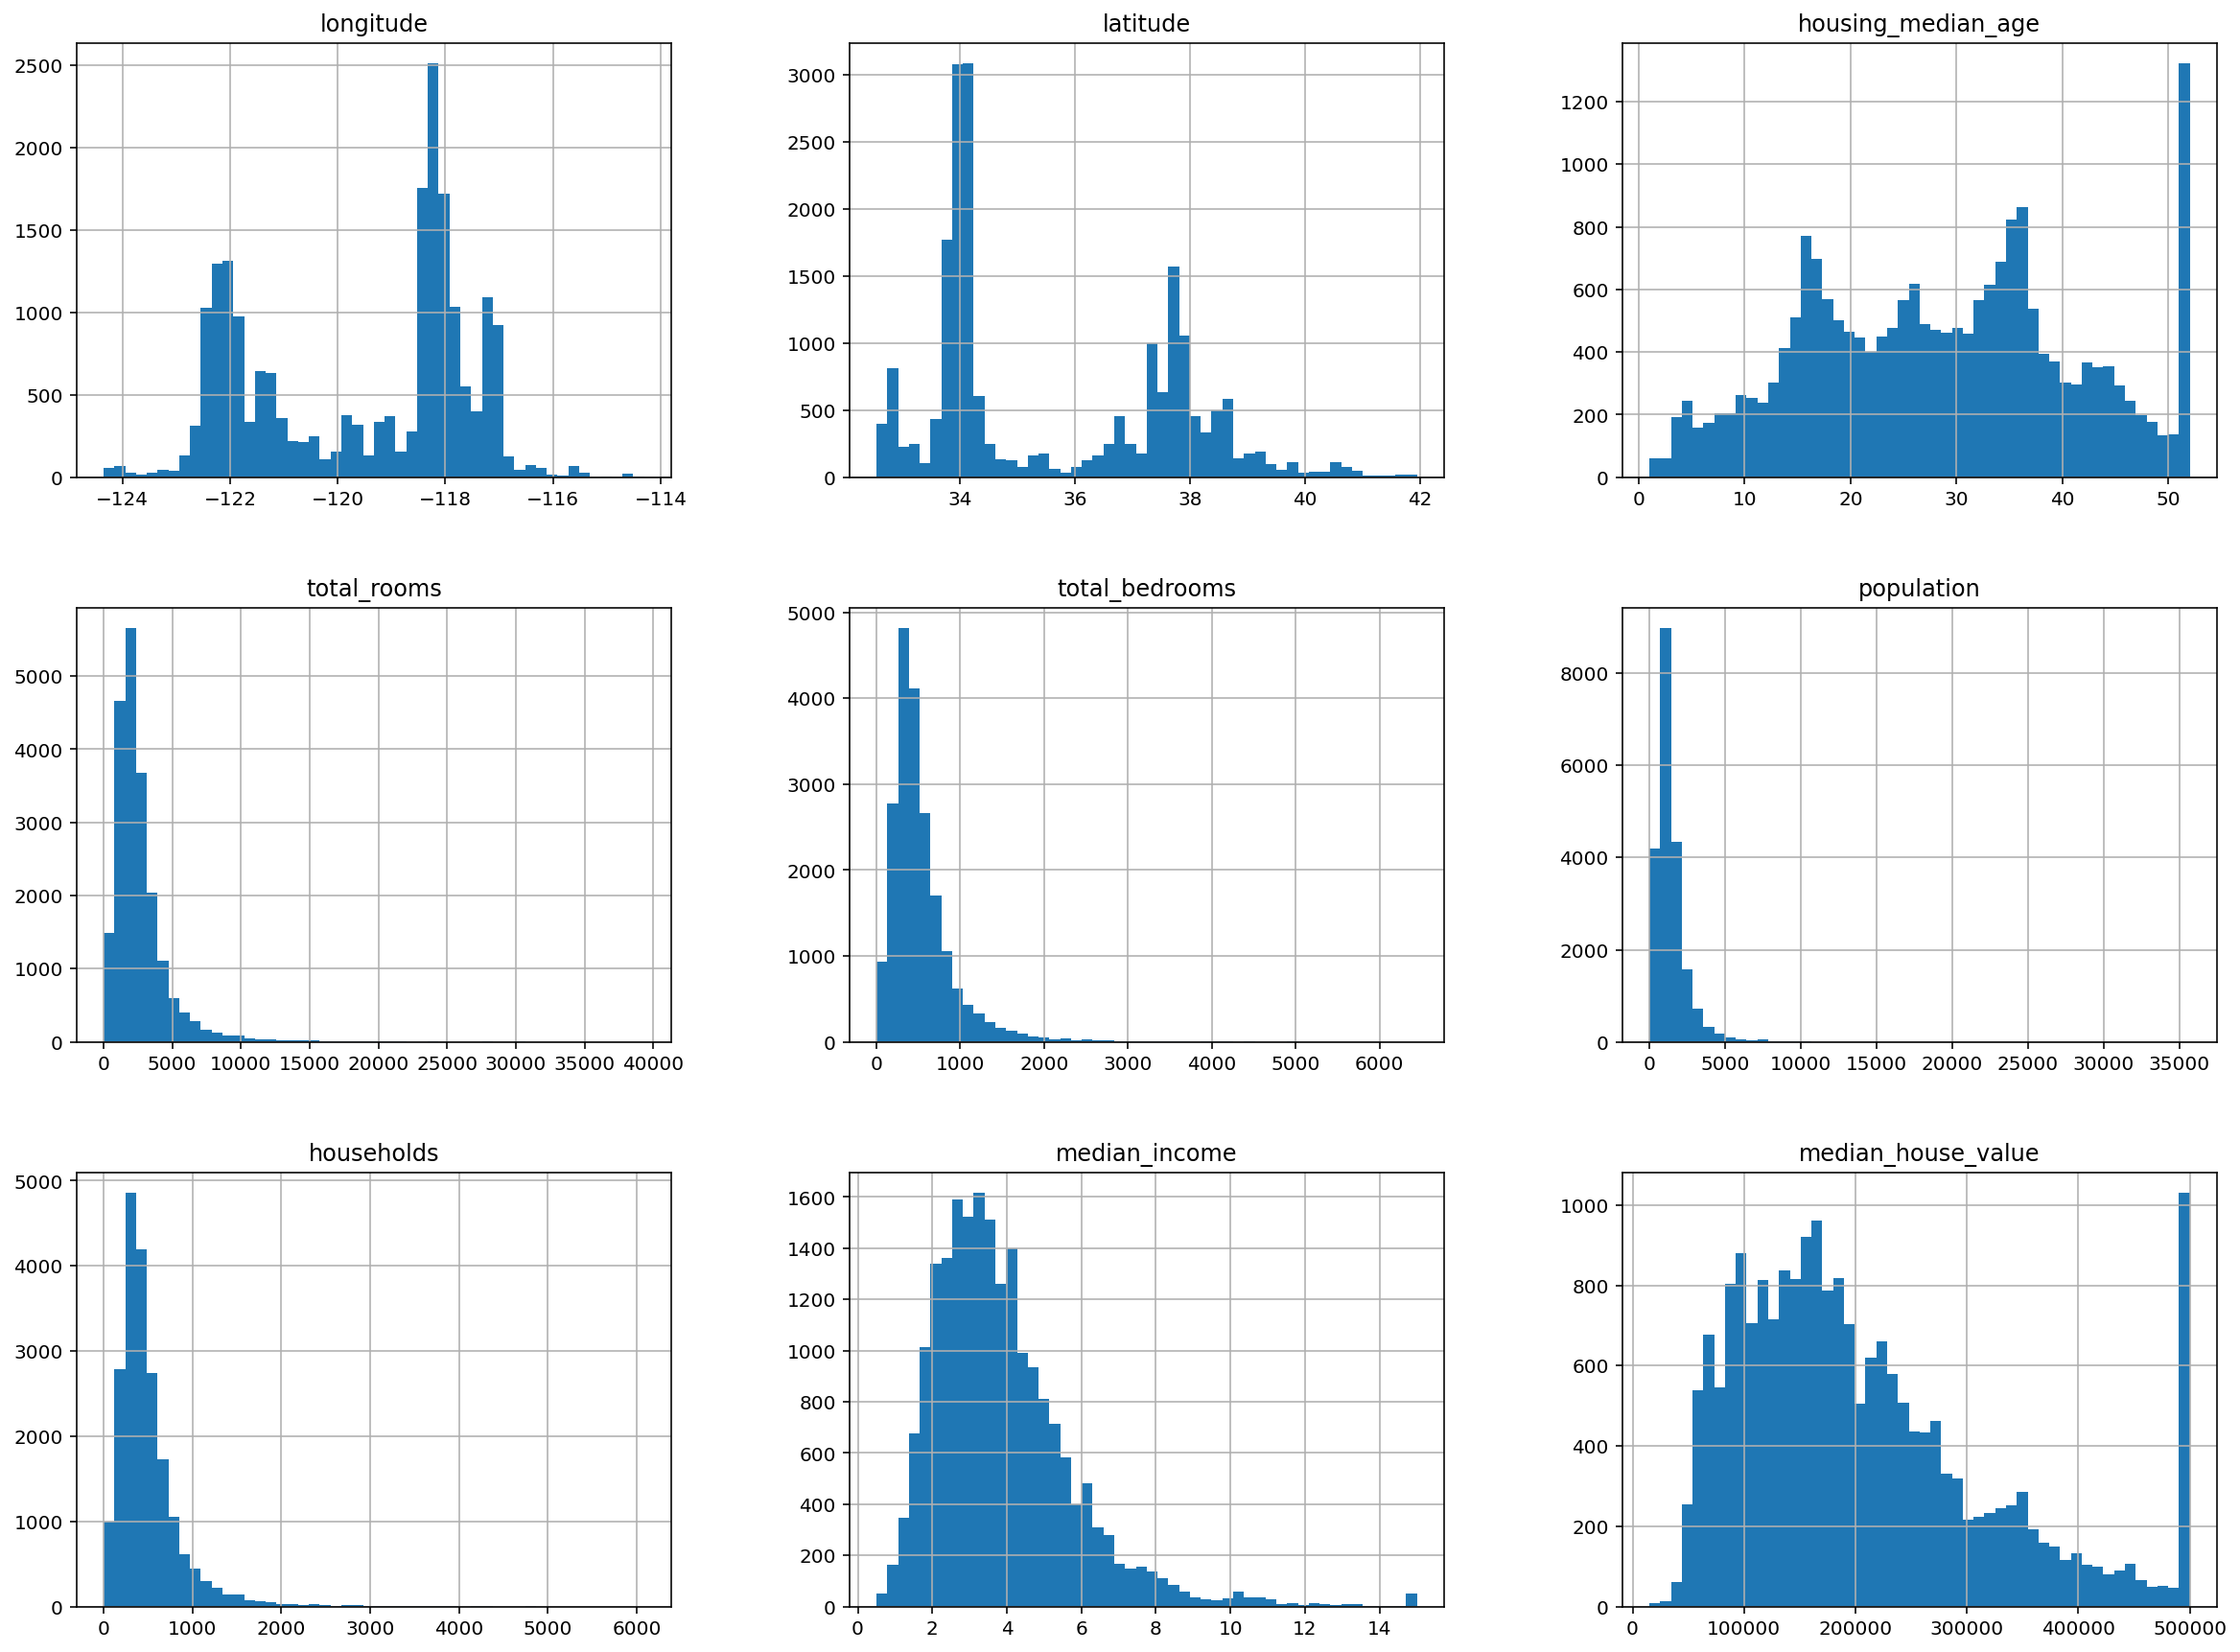

In [24]:
%matplotlib inline
_ = data.hist(bins=50, figsize=(20,15))

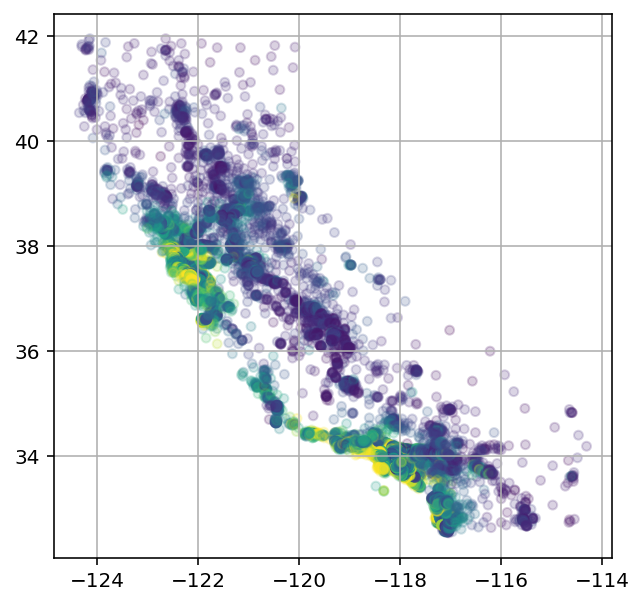

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(data.longitude, data.latitude, s=20, c=data.median_house_value, zorder=1, alpha=0.2)
ax.grid()


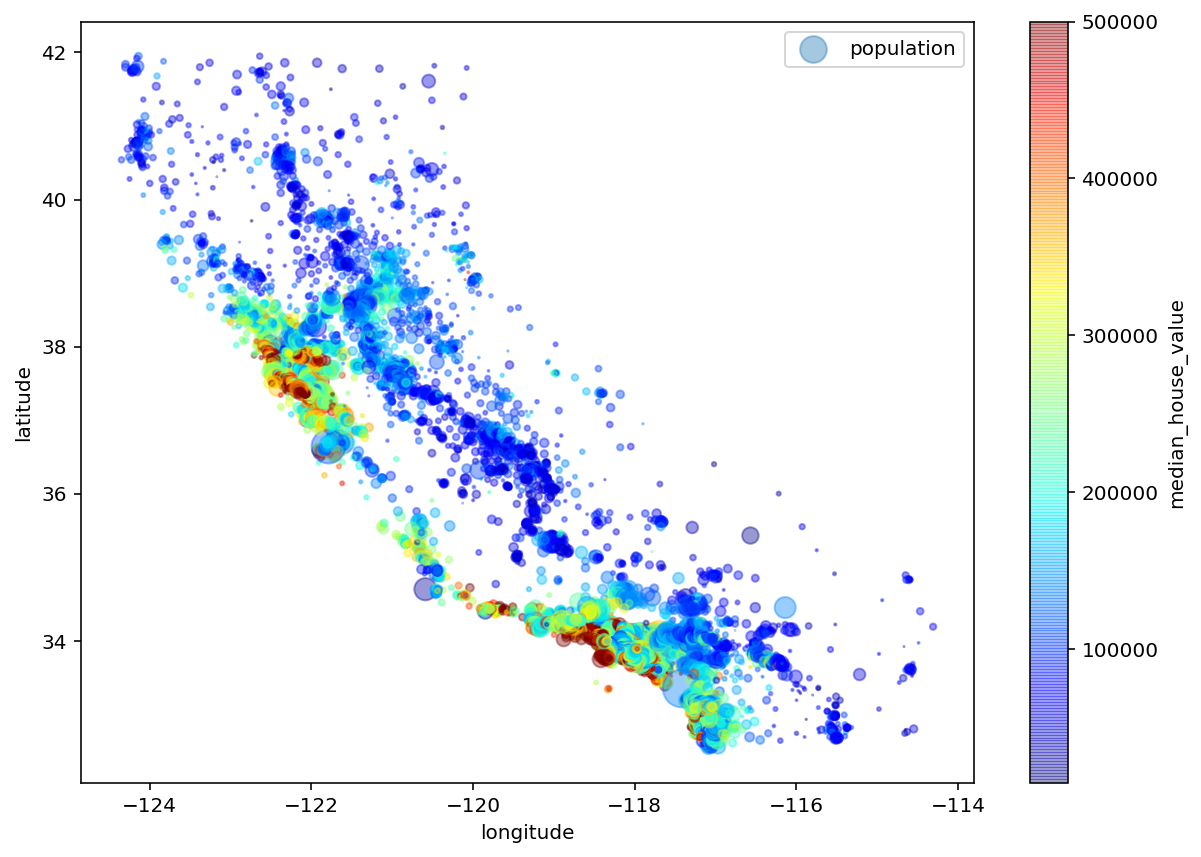

In [23]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
_ = plt.legend()

In [31]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [32]:
figures = []
figures.append(go.Scattermapbox(lon=data['longitude'], lat=data['latitude'],
                                mode='markers',marker={'color':data['median_house_value'],
                                                       'colorscale':'RdPu','size':data['population']/350}))

fig = go.Figure(figures)
map_center = go.layout.mapbox.Center(lon=data['longitude'].mean(), lat=data['latitude'].mean())
fig.update_layout(mapbox_style="open-street-map",
                  mapbox=dict(center=map_center, zoom=8))
fig.show()

In [29]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
 10  county              20640 non-null  category
dtypes: category(2), float64(9)
memory usage: 1.5 MB


In [28]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
county                  0
dtype: int64

In [34]:
import feature_engine.missing_data_imputers as mdi
median_imputer = mdi.MeanMedianImputer(imputation_method='median',
                                      variables=['total_bedrooms'])

median_imputer.fit(data)

ModuleNotFoundError: No module named 'feature_engine.missing_data_imputers'

In [35]:
data.total_bedrooms.fillna(data.total_bedrooms.mean(), inplace=True)

In [39]:
data["rooms_per_household"] = data["total_rooms"]/data["households"] # количество комнат в среднем на дом
data["bedrooms_per_household"] = data["total_bedrooms"]/data["households"] 
data["bedrooms_per_room"] = data["total_bedrooms"]/data["total_rooms"] # количество спалень в среднем на дом
data["population_per_household"]=data["population"]/data["households"] # среднее количество людей проживающих в одном доме

In [40]:
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049454
population_per_household   -0.023737
population                 -0.024650
bedrooms_per_household     -0.044265
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.220049
Name: median_house_value, dtype: float64

In [41]:
data = pd.get_dummies(data, columns=['ocean_proximity', 'county'])


In [42]:
data

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

       rooms_per_household  ...  county_Stanislaus  county_Sutter  \
0                 6.984127  ...                  0              0   
1                 6.238137  ...                  0              0   
2                 8.288136  ...                  0              0   
3                 5.817352  ...                  0              0   
4                 6.281853  ...                  0              0   
...                    ...  ...                ...            ...   
20635             5.045455  ...                  0              0   
20636             6.114035  ...                  0              0   
20637             5.205543  ...                  0              0   
20638             5.329513  ...                  0              0   
20639             5.254717  ...                  0              0   

       county_Tehama  county_Trinity  county_Tulare  county_Tuolumne  \
0                  0               0              0                0   
1                  0               0              0                0   
2                  0               0              0                0   
3                  0               0              0                0   
4                  0               0              0                0   
...              ...             ...            ...              ...   
20635              0               0              0                0   
20636              0               0              0                0   
20637              0               0              0                0   
20638              0               0              0                0   
20639              0               0              0                0   

       county_Ventura  county_Yolo  county_Yuba  county_unknown  
0                   0            0            0               0  
1                   0            0            0               0  
2                   0            0            0               0  
3                   0            0            0               0  
4                   0            0            0               0  
...               ...          ...          ...             ...  
20635               0            0            1               0  
20636              

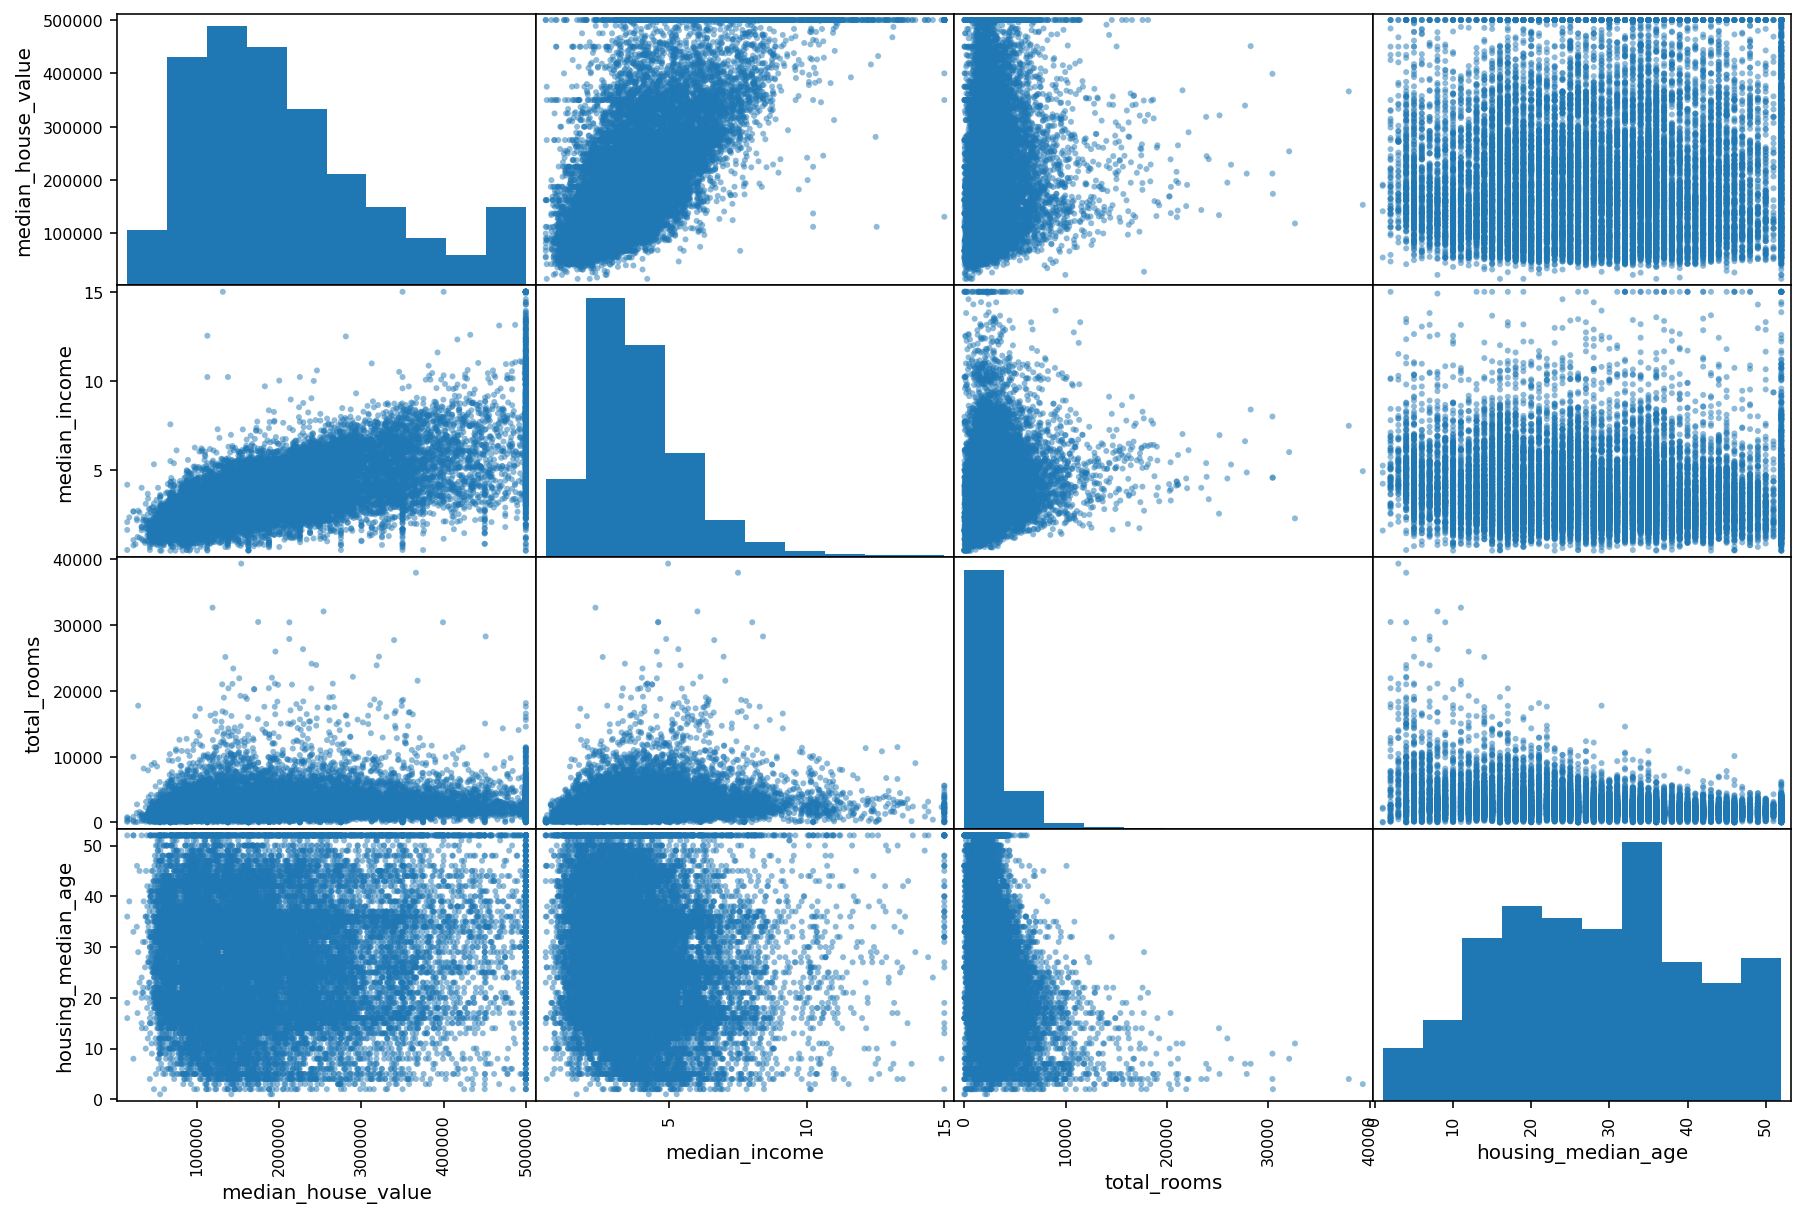

In [47]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
_ = scatter_matrix(data[attributes], figsize=(15, 10))

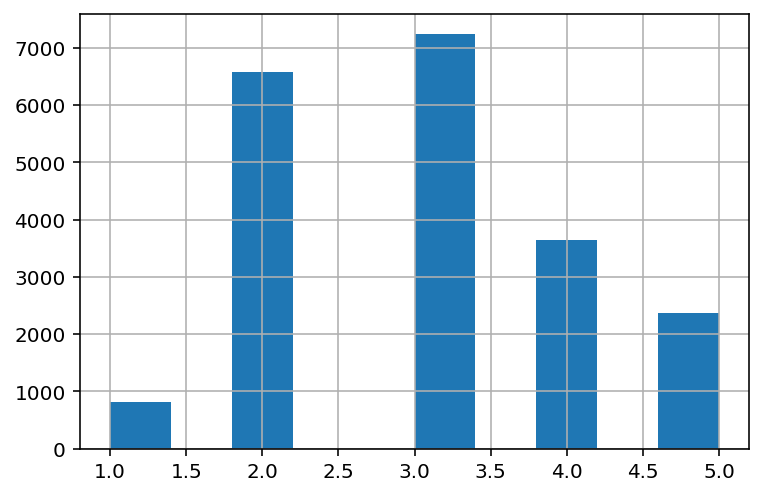

In [50]:
# Делим на 1.5 с целью уменьшения количества категорий (т.е. объединяем мелкие категории в одну 5-ю)
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
# Обозначаем тех, кто выше 5 как 5
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)
data["income_cat"].hist();

In [36]:
from sklearn.model_selection import train_test_split

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit # разбиение с сохранением распределения по категориям

split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [52]:
X_train = strat_train_set.drop(['median_house_value'], axis=1)
y_train = strat_train_set['median_house_value']

In [53]:
X_test = strat_test_set.drop(['median_house_value'], axis=1)
y_test = strat_test_set['median_house_value']

In [54]:
from sklearn.linear_model import LinearRegression

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 80 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   total_rooms                 20640 non-null  float64
 4   total_bedrooms              20640 non-null  float64
 5   population                  20640 non-null  float64
 6   households                  20640 non-null  float64
 7   median_income               20640 non-null  float64
 8   median_house_value          20640 non-null  float64
 9   rooms_per_household         20640 non-null  float64
 10  bedrooms_per_room           20640 non-null  float64
 11  population_per_household    20640 non-null  float64
 12  bedrooms_per_household      20640 non-null  float64
 13  ocean_proximity_<1H OCEAN   206

In [58]:
model = LinearRegression(normalize=False, n_jobs=-1) # параметр normalize=True сразу стандартизирует значения

In [59]:
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [60]:
y_predict= model.predict(X_test)

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print('MSE = ',mean_squared_error(y_test, y_predict))
print('Ср.абс.ош. = ',mean_absolute_error(y_test, y_predict))

MSE =  4040490556.7401795
Ср.абс.ош. =  44898.734212990115
